## Homework 9: Serverless Deep Learning with AWS Lambda

In this homework, we'll deploy the bees vs wasps model we trained in the 
[previous homework](../08-deep-learning/homework.md).

Download the model from here: 

https://github.com/alexeygrigorev/large-datasets/releases/download/wasps-bees/bees-wasps.h5


In [16]:
#!wget https://github.com/alexeygrigorev/large-datasets/releases/download/wasps-bees/bees-wasps.h5

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import load_img
import numpy as np
import tensorflow.lite as tflite

tf.__version__

'2.15.0'

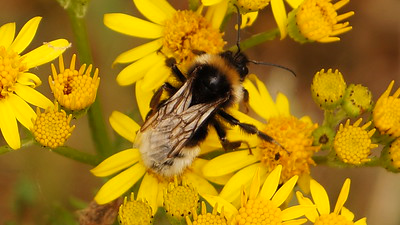

In [3]:
beepath = './21004953130_03d69a5dee_w.jpg'
wasppath= './2088223000_516db96b84_n.jpg'
load_img(beepath)

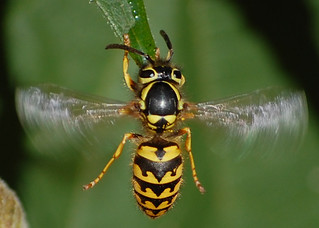

In [4]:
load_img(wasppath)

In [7]:
model = tf.keras.models.load_model('bees-wasps.h5', compile=False)
input_shape = model.input_shape
output_shape = model.output_shape
print("Input shape:", input_shape)
print("Output shape:", output_shape)

2023-11-30 12:39:37.711190: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 44859392 exceeds 10% of free system memory.


Input shape: (None, 150, 150, 3)
Output shape: (None, 1)


In [8]:
def make_array(path, target_tuple):
    img = image.load_img(path, target_size=target_tuple)  # Adjust the target size according to your model's input shape
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = img_array / 255.0  # Normalize the image data
    return img_array

In [9]:
Xbee = make_array(beepath, (150,150))
Xbee.shape

(1, 150, 150, 3)

In [10]:
predictions = model.predict(Xbee)

1/1 [==============================] - 0s 271ms/step


In [11]:
classes = ['bee', 'wasp']
threshold = 0.5

predicted_label = classes[1 if predictions[0] >= threshold else 0]
print("Predicted class:", predicted_label)

Predicted class: bee


In [12]:
Xwasp = make_array(wasppath, (150,150))
predictions = model.predict(Xwasp)
predicted_label = classes[1 if predictions[0] >= threshold else 0]
print("Predicted class:", predicted_label)

1/1 [==============================] - 0s 61ms/step
Predicted class: wasp


## Question 1

Now convert this model from Keras to TF-Lite format.

In [20]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)

tflite_model = converter.convert()

with open('bee-wasp.tflite', 'wb') as f_out:
    f_out.write(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmpls4x4237/assets


INFO:tensorflow:Assets written to: /tmp/tmpls4x4237/assets
2023-11-30 12:45:25.866664: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2023-11-30 12:45:25.866734: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2023-11-30 12:45:25.867390: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpls4x4237
2023-11-30 12:45:25.869685: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2023-11-30 12:45:25.869722: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmpls4x4237
2023-11-30 12:45:25.873984: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2023-11-30 12:45:26.021846: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmpls4x4237
2023-11-30 12:45:26.048757: I tensorflow/cc/saved_model/loader.cc:316] SavedModel

In [21]:
!ls -lh bee-wasp.tflite

-rw-rw-r-- 1 jdiabl0 jdiabl0 43M Nov 30 12:45 bee-wasp.tflite


What's the size of the **converted** model?

* 21 Mb
* 43 Mb  <--
* 80 Mb
* 164 Mb

## Question 2

To be able to use this model, we need to know the index of the input and 
the index of the output. 

In [22]:
interpreter = tflite.Interpreter(model_path='bee-wasp.tflite')
interpreter.allocate_tensors()

interpreter.get_input_details()

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


[{'name': 'serving_default_conv2d_input:0',
  'index': 0,
  'shape': array([  1, 150, 150,   3], dtype=int32),
  'shape_signature': array([ -1, 150, 150,   3], dtype=int32),
  'dtype': numpy.float32,
  'quantization': (0.0, 0),
  'quantization_parameters': {'scales': array([], dtype=float32),
   'zero_points': array([], dtype=int32),
   'quantized_dimension': 0},
  'sparsity_parameters': {}}]

In [23]:
interpreter.get_output_details()

[{'name': 'StatefulPartitionedCall:0',
  'index': 13,
  'shape': array([1, 1], dtype=int32),
  'shape_signature': array([-1,  1], dtype=int32),
  'dtype': numpy.float32,
  'quantization': (0.0, 0),
  'quantization_parameters': {'scales': array([], dtype=float32),
   'zero_points': array([], dtype=int32),
   'quantized_dimension': 0},
  'sparsity_parameters': {}}]

What's the output index for this model?

* 3
* 7
* 13  <--
* 24

## Preparing the image

We'll need some code for downloading and resizing images.

In [18]:
#!pip install pillow

In [24]:
from io import BytesIO
from urllib import request

from PIL import Image

def download_image(url):
    with request.urlopen(url) as resp:
        buffer = resp.read()
    stream = BytesIO(buffer)
    img = Image.open(stream)
    return img


def prepare_image(img, target_size):
    if img.mode != 'RGB':
        img = img.convert('RGB')
    img = img.resize(target_size, Image.NEAREST)
    return img

Let's download and resize this image: 

https://habrastorage.org/webt/rt/d9/dh/rtd9dhsmhwrdezeldzoqgijdg8a.jpeg

Based on the previous testing(and homework 8) , the target size for the image should be (150, 150).

In [25]:
url = 'https://habrastorage.org/webt/rt/d9/dh/rtd9dhsmhwrdezeldzoqgijdg8a.jpeg'
image = download_image(url)

In [26]:
image = prepare_image(image, (150, 150))

## Question 3

Now we need to turn the image into numpy array and pre-process it. 

In [27]:
def make_X_array(img):
    x_array = np.array(img, dtype='float32')
    X_array = np.array([x_array])
    X_array = X_array / 255.0
    return X_array

In [28]:
X = make_X_array(image)

In [29]:
X.shape

(1, 150, 150, 3)

In [30]:
X[0,0,0,0]

0.94509804

After the pre-processing, what's the value in the first pixel, the R channel?

* 0.3450980
* 0.5450980
* 0.7450980
* 0.9450980  <--

## Question 4

Now let's apply this model to this image. What's the output of the model?

* 0.258
* 0.458
* 0.658  <--
* 0.858

In [31]:
input_index = interpreter.get_input_details()[0]['index']
output_index = interpreter.get_output_details()[0]['index']

In [32]:
interpreter.set_tensor(input_index, X)
interpreter.invoke()

In [33]:
preds = interpreter.get_tensor(output_index)
preds

array([[0.65898407]], dtype=float32)

In [34]:
predicted_label = classes[1 if preds[0] >= threshold else 0]
print("Predicted class:", predicted_label)

Predicted class: wasp


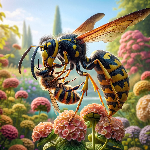

In [35]:
image

## Prepare the lambda code 

Now you need to copy all the code into a separate python file. You will 
need to use this file for the next two questions.

Tip: you can test this file locally with `ipython` or Jupyter Notebook 
by importing the file and invoking the function from this file.  


In [36]:
#!pip install --extra-index-url https://google-coral.github.io/py-repo/ tflite_runtime

In [37]:
import numpy as np
import tflite_runtime.interpreter as tflite

In [38]:
from io import BytesIO
from urllib import request

from PIL import Image

def download_image(url):
    with request.urlopen(url) as resp:
        buffer = resp.read()
    stream = BytesIO(buffer)
    img = Image.open(stream)
    return img


def prepare_image(img, target_size):
    if img.mode != 'RGB':
        img = img.convert('RGB')
    img = img.resize(target_size, Image.NEAREST)
    return img

In [39]:
def make_X_array(img):
    x_array = np.array(img, dtype='float32')
    X_array = np.array([x_array])
    X_array = X_array / 255.0
    return X_array

In [40]:
interpreter = tflite.Interpreter(model_path='bee-wasp.tflite')
interpreter.allocate_tensors()

input_index = interpreter.get_input_details()[0]['index']
output_index = interpreter.get_output_details()[0]['index']

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


In [41]:
url = 'https://habrastorage.org/webt/rt/d9/dh/rtd9dhsmhwrdezeldzoqgijdg8a.jpeg'
image = download_image(url)
image = prepare_image(image, (150, 150))
X = make_X_array(image)

In [42]:
interpreter.set_tensor(input_index, X)
interpreter.invoke()

preds = interpreter.get_tensor(output_index)

In [43]:
classes = ['bee', 'wasp']
threshold = 0.5

predicted_label = classes[1 if preds[0] >= threshold else 0]
print("Predicted class:", predicted_label)

Predicted class: wasp


In [45]:
#import serverlessLambda

In [46]:
#serverlessLambda.predict('https://habrastorage.org/webt/rt/d9/dh/rtd9dhsmhwrdezeldzoqgijdg8a.jpeg')

In [47]:
#event = {'url': 'https://habrastorage.org/webt/rt/d9/dh/rtd9dhsmhwrdezeldzoqgijdg8a.jpeg'}
#serverlessLambda.lambda_handler(event, None)

## Docker 

For the next two questions, we'll use a Docker image that we already 
prepared. This is the Dockerfile that we used for creating the image:

```docker
FROM public.ecr.aws/lambda/python:3.10
COPY bees-wasps-v2.tflite .
```

And pushed it to [`agrigorev/zoomcamp-bees-wasps:v2`](https://hub.docker.com/r/agrigorev/zoomcamp-bees-wasps/tags).

A few notes:

* The image already contains a model and it's not the same model
  as the one we used for questions 1-4.
* The version of Python is 3.10, so you need to use the right wheel for 
  TF-Lite. For Tensorflow 2.14.0, it's https://github.com/alexeygrigorev/tflite-aws-lambda/raw/main/tflite/tflite_runtime-2.14.0-cp310-cp310-linux_x86_64.whl


## Question 5

Download the base image `agrigorev/zoomcamp-bees-wasps:v2`. You can easily make it by using [docker pull](https://docs.docker.com/engine/reference/commandline/pull/) command.


In [48]:
#!docker pull agrigorev/zoomcamp-bees-wasps:v2
!docker images --filter "reference=agrigorev/zoomcamp-bees-wasps:v2"

REPOSITORY                      TAG       IMAGE ID       CREATED       SIZE
agrigorev/zoomcamp-bees-wasps   v2        b9f6c13de368   12 days ago   662MB


So what's the size of this base image?

* 162 Mb
* 362 Mb
* 662 Mb  <--
* 962 Mb

You can get this information when running `docker images` - it'll be in the "SIZE" column.

# Question 6

Now let's extend this docker image, install all the required libraries
and add the code for lambda.

You don't need to include the model in the image. It's already included. 
The name of the file with the model is `bees-wasps-v2.tflite` and it's 
in the current workdir in the image (see the Dockerfile above for the 
reference). 
The provided model requires the same preprocessing for images regarding target size and rescaling the value range than used in homework 8.


In [49]:
#!docker build -t bees-wasps .
!docker images --filter "reference=bees-wasps:latest"

REPOSITORY   TAG       IMAGE ID       CREATED          SIZE
bees-wasps   latest    c9f958d343a2   23 minutes ago   778MB


Now run the container locally.

Score this image: https://habrastorage.org/webt/rt/d9/dh/rtd9dhsmhwrdezeldzoqgijdg8a.jpeg

In [51]:
import requests

url = 'http://localhost:8080/2015-03-31/functions/function/invocations'

data = {'url': 'https://habrastorage.org/webt/rt/d9/dh/rtd9dhsmhwrdezeldzoqgijdg8a.jpeg'}

result = requests.post(url, json=data).json()
print(result)

{'prediction': 0.44533514976501465}


What's the output from the model?

* 0.2453
* 0.4453  <--
* 0.6453
* 0.8453



## Publishing it to AWS

Now you can deploy your model to AWS!

* Publish your image to ECR
* Create a lambda function in AWS, use the ECR image
* Give it more RAM and increase the timeout 
* Test it
* Expose the lambda function using API Gateway

This is optional and not graded.


## Publishing to Docker hub

This is just for reference, this is how we published our image to Docker hub:

```bash
docker build -t zoomcamp-bees-wasps -f homework.dockerfile .
docker tag zoomcamp-bees-wasps:latest agrigorev/zoomcamp-bees-wasps:v2
docker push agrigorev/zoomcamp-bees-wasps:v2
```

